In [18]:
trainImages=('dataset/')
test_features= ('test_features.csv')
features= ('features.csv')
testImages= ('test/')


In [48]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

from sklearn.cluster import KMeans,DBSCAN,MeanShift
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.spatial.distance import cdist
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting library
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
import shutil
from random import sample


# Phase 1

In [20]:
image_data = pd.read_csv(features)
image_data

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,049996.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
49996,049997.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
49997,049998.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
49998,049999.jpg,-1,1,1,1,-1,-1,1,1,-1,...,-1,1,-1,1,-1,1,1,-1,-1,1


get image address

In [118]:
# Get a list of all image files in the directory
image_files = [f for f in os.listdir(trainImages) if f.lower().endswith(('.jpg'))]

# Print the list of image files
print("Image files found:", image_files)

Image files found: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', 

In [119]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return faces  # برمی‌گرداند مختصات صورت


In [ ]:
results = []
def get_skin_color(face_image):
    hsv = cv2.cvtColor(face_image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)
    skin_pixels = cv2.bitwise_and(face_image, face_image, mask=skin_mask)

    mean_color_bgr = cv2.mean(skin_pixels, mask=skin_mask)[:3]  
    mean_color_rgb = cv2.cvtColor(np.uint8([[mean_color_bgr]]), cv2.COLOR_BGR2RGB)[0][0] 
    return mean_color_rgb


def get_eye_color(face_image, eye_coords):

    eye_region = face_image[eye_coords[1]:eye_coords[3], eye_coords[0]:eye_coords[2]]

    if eye_region.size == 0:
        return None

    mean_color = cv2.mean(eye_region)[:3]  
    mean_color_rgb = cv2.cvtColor(np.uint8([[mean_color]]), cv2.COLOR_BGR2RGB)[0][0]
    return mean_color_rgb  


for i in image_files:
  tesstttt  = trainImages + i
  img = cv2.imread(tesstttt)
  face_coordinates = detect_face(tesstttt)  
  print(i)
  for (x, y, w, h) in face_coordinates:
      face_image = img[y:y+h, x:x+w]
      skin_color = get_skin_color(face_image)  
      mean_skin_color=  None

      if skin_color is not None:
        mean_skin_color = (int(skin_color[0]) + int(skin_color[1]) +int(skin_color[2])) / 3


      eye_coords = (x + int(w*0.15), y + int(h*0.20), x + int(w*0.47), y + int(h*0.57))

      eye_color = get_eye_color(face_image, eye_coords)  

      mean_eye_color=  None
      if eye_color is not None:
         mean_eye_color = (int(eye_color[0]) + int(eye_color[1]) +int(eye_color[2])) / 3

      results.append({"image_id": i, "mean_skin_color": mean_skin_color, "mean_eye_color": mean_eye_color})


df = pd.DataFrame(results)

df_combined = pd.merge(image_data, df, on='image_id', how='outer')

df_combined




000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg
000020.jpg
000021.jpg
000022.jpg
000023.jpg
000024.jpg
000025.jpg
000026.jpg
000027.jpg
000028.jpg
000029.jpg
000030.jpg
000031.jpg
000032.jpg
000033.jpg
000034.jpg
000035.jpg
000036.jpg
000037.jpg
000038.jpg
000039.jpg
000040.jpg
000041.jpg
000042.jpg
000043.jpg
000044.jpg
000045.jpg
000046.jpg
000047.jpg
000048.jpg
000049.jpg
000050.jpg
000051.jpg
000052.jpg
000053.jpg
000054.jpg
000055.jpg
000056.jpg
000057.jpg
000058.jpg
000059.jpg
000060.jpg
000061.jpg
000062.jpg
000063.jpg
000064.jpg
000065.jpg
000066.jpg
000067.jpg
000068.jpg
000069.jpg
000070.jpg
000071.jpg
000072.jpg
000073.jpg
000074.jpg
000075.jpg
000076.jpg
000077.jpg
000078.jpg
000079.jpg
000080.jpg
000081.jpg
000082.jpg
000083.jpg
000084.jpg
000085.jpg
000086.jpg
000087.jpg
000088.jpg
000089.jpg
000090.jpg
000091.jpg

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,mean_skin_color,mean_eye_color
0,000001.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,170.333333,195.000000
1,000002.jpg,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,158.000000,161.000000
2,000003.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,NaN
3,000004.jpg,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,143.000000,153.000000
4,000005.jpg,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,161.000000,184.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50997,049996.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,125.666667,146.000000
50998,049997.jpg,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,128.000000,82.333333
50999,049998.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,168.666667,186.000000
51000,049999.jpg,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,...,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,150.333333,119.000000


In [121]:
df_combined.to_csv("df_combined.csv", index=True)


In [122]:
df_combined=pd.read_csv("df_combined.csv")
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51002 entries, 0 to 51001
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           51002 non-null  int64  
 1   image_id             51002 non-null  object 
 2   5_o_Clock_Shadow     50974 non-null  float64
 3   Arched_Eyebrows      50974 non-null  float64
 4   Attractive           50974 non-null  float64
 5   Bags_Under_Eyes      50974 non-null  float64
 6   Bald                 50974 non-null  float64
 7   Bangs                50974 non-null  float64
 8   Big_Lips             50974 non-null  float64
 9   Big_Nose             50974 non-null  float64
 10  Black_Hair           50974 non-null  float64
 11  Blond_Hair           50974 non-null  float64
 12  Blurry               50974 non-null  float64
 13  Brown_Hair           50974 non-null  float64
 14  Bushy_Eyebrows       50974 non-null  float64
 15  Chubby               50974 non-null 

# Phase 2
# Pearson Correlation


In [3]:
features=pd.read_csv(features)

pearsonC = features.drop(columns=['image_id'])
# libcorr=pearsonC.corr(method='pearson')
# libcorr


In [4]:

def pearson_corr_matrix(df):
    cols = df.columns
    corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(i, len(cols)):
            x = df[cols[i]].values
            y = df[cols[j]].values


            x_mean = np.mean(x)
            y_mean = np.mean(y)
            x_diff = x - x_mean
            y_diff = y - y_mean
            numerator = np.sum(x_diff * y_diff)
            denominator = np.sqrt(np.sum(x_diff**2) * np.sum(y_diff**2))
            correlation = numerator / denominator

            corr_matrix.iloc[i, j] = correlation
            corr_matrix.iloc[j, i] = correlation

    return corr_matrix


<Axes: >

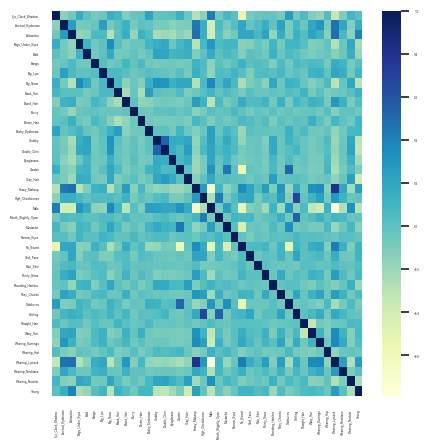

In [5]:
corr_matrix=pearson_corr_matrix(pearsonC)
plt.figure(figsize=(5,5))
sns.set(font_scale=0.2)
sns.heatmap(corr_matrix,cmap='YlGnBu',annot=False)

feature selection Based on threashhold

Features that satisfy the threshhold

In [6]:
def select_features_by_correlation(df_corr, threshold):


    selected_features = []
    
  
    for feature in df_corr.columns:
        feature_selected = True
        
       
        for selected in selected_features:
           
            if abs(df_corr.at[feature, selected]) >= threshold:
                feature_selected = False
                break
        
      
        if feature_selected:
            selected_features.append(feature)
     
    return selected_features

In [7]:
selected_features=select_features_by_correlation(corr_matrix,.06)
seleceted_features_df=features[selected_features]
seleceted_features_df

,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose
0,-1,-1,-1,-1,-1,1
1,-1,-1,-1,-1,-1,-1
2,-1,-1,1,1,-1,1
3,-1,-1,-1,-1,-1,1
4,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...
49995,-1,-1,-1,-1,-1,1
49996,-1,-1,-1,-1,-1,1
49997,-1,-1,-1,-1,-1,-1
49998,-1,-1,1,-1,-1,-1


In [68]:
pearson_corr_matrix(seleceted_features_df)

,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose
5_o_Clock_Shadow,1.000000,0.007525,-0.044157,-0.031342,-0.038736,-0.024447
Bald,0.007525,1.000000,0.000379,-0.009016,-0.018288,-0.057184
Big_Lips,-0.044157,0.000379,1.000000,-0.041550,0.039522,0.052071
Blurry,-0.031342,-0.009016,-0.041550,1.000000,-0.016046,-0.052030
Pale_Skin,-0.038736,-0.018288,0.039522,-0.016046,1.000000,0.007182
Pointy_Nose,-0.024447,-0.057184,0.052071,-0.052030,0.007182,1.000000


# Phase 3
## Lbow and sillhoute method for finding best K

In [217]:
inertia_value=[]
silhouette_scores = []
n_cluster=range(3,20)

for i in n_cluster:
    kmean=KMeans(n_clusters=i,random_state=42)
    kmean.fit(seleceted_features_df)
    
    inertia_value.append(kmean.inertia_) 

    y_pred=kmean.predict(seleceted_features_df)
    silhouette_avg = silhouette_score(seleceted_features_df, y_pred)
    silhouette_scores.append(silhouette_avg)

<module 'matplotlib.pyplot' from 'C:\\Users\\Kia\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

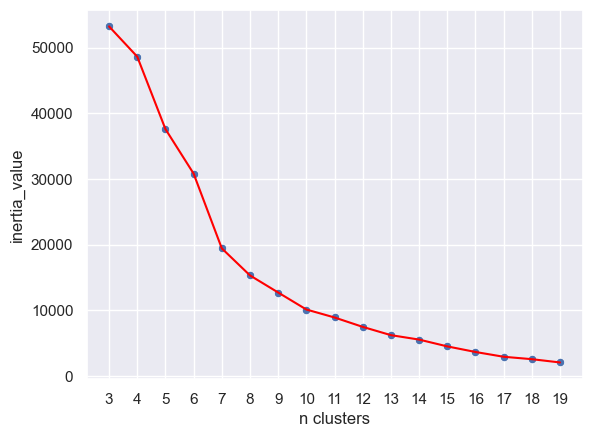

In [218]:
sns.set(font_scale=1)
sns.scatterplot(x=n_cluster,y=inertia_value)
plt.plot(n_cluster,inertia_value,c="red")
plt.xlabel("n clusters")
plt.ylabel("inertia_value")
plt.xticks(n_cluster)
plt

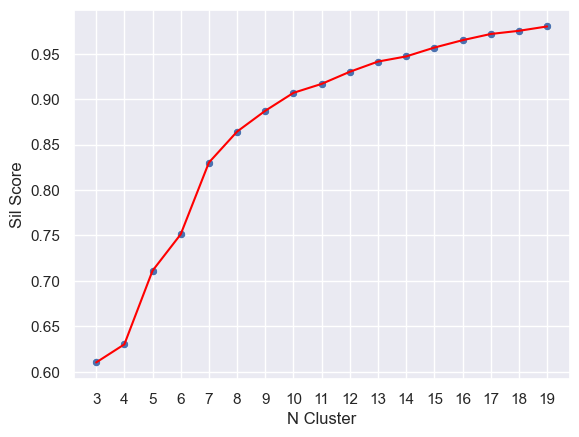

In [219]:
plt.figure()
sns.scatterplot(x=n_cluster,y=silhouette_scores)
sns.lineplot(x=n_cluster,y=silhouette_scores,color = 'red')
plt.xlabel('N Cluster')
plt.ylabel('Sil Score')
plt.xticks(n_cluster)
plt.show()

# hypertuning  Kmeans
hyper parameters: number of k , init , n_init , max_iter 
metric = Silhouette Score ,  Davies-Bouldin Index (DBI) ,  Calinski-Harabasz Index (Variance Ratio Criterion)

In [265]:
k_values = [7]  
init_methods = ['k-means++', 'random'] 
n_init_values = [10, 20]  
max_iter_values = [300, 500]  
algorithms = ['lloyd', 'elkan']  
results = []


for k in k_values:
    for init_method in init_methods:
        for n_init in n_init_values:
            for max_iter in max_iter_values:
                for algorithm in algorithms:

                    kmeans = KMeans(n_clusters=k, init=init_method, n_init=n_init, max_iter=max_iter,algorithm=algorithm ,random_state=42)
                    kmeans.fit(seleceted_features_df)
                    
                    labels = kmeans.labels_
                    
                    inertia = kmeans.inertia_
                    silhouette_avg = silhouette_score(seleceted_features_df, labels)
                    davies_bouldin = davies_bouldin_score(seleceted_features_df, labels)
                    calinski_harabasz = calinski_harabasz_score(seleceted_features_df, labels)
                    
                    results.append({
                        'K': k,
                        'init': init_method,
                        'n_init': n_init,
                        'max_iter': max_iter,
                        'algorithm': algorithm,
                        'Inertia': inertia,
                        'Silhouette Score': silhouette_avg,
                        'Davies-Bouldin Index': davies_bouldin,
                        'Calinski-Harabasz Index': calinski_harabasz
                    })
results_df = pd.DataFrame(results)

In [289]:
results_df.sort_values(by=["Calinski-Harabasz Index"])

,K,init,n_init,max_iter,algorithm,Inertia,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
8,7,random,10,300,lloyd,23919.397944,0.802293,0.572058,32995.208239
10,7,random,10,500,lloyd,23919.397944,0.802293,0.572058,32995.208239
12,7,random,20,300,lloyd,23919.397944,0.802293,0.572058,32995.208239
14,7,random,20,500,lloyd,23919.397944,0.802293,0.572058,32995.208239
9,7,random,10,300,elkan,23390.309740,0.807430,0.564116,33930.032394
11,7,random,10,500,elkan,23390.309740,0.807430,0.564116,33930.032394
13,7,random,20,300,elkan,23390.309740,0.807430,0.564116,33930.032394
15,7,random,20,500,elkan,23390.309740,0.807430,0.564116,33930.032394
1,7,k-means++,10,300,elkan,19654.757855,0.833730,0.423287,41962.318446
3,7,k-means++,10,500,elkan,19654.757855,0.833730,0.423287,41962.318446


Best Parameters number of k :9  init : kmeans++  n_init: no difference , max_iter: no difference , algorithm ="lloyd"

# Kmeans Clustering

In [8]:
Kmeans_Clustering= KMeans(7, init="k-means++",algorithm="lloyd" ,random_state=42)
Kmeans_Clustering.fit(seleceted_features_df)
labels = Kmeans_Clustering.labels_
metrics=[]
metrics.append({
            'Silhouette Score': silhouette_score(seleceted_features_df, labels),
            'Davies-Bouldin Index': davies_bouldin_score(seleceted_features_df, labels),
            'Calinski-Harabasz Index': calinski_harabasz_score(seleceted_features_df, labels),
            'Inertia': Kmeans_Clustering.inertia_,
        })
metrics_df=pd.DataFrame(metrics)
metrics_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Inertia
0,0.83023,0.531267,42595.932046,19410.226404


In [9]:
# Convert to DataFrame for easier manipulation
clustered=seleceted_features_df.copy()

clustered["kmeans"]=labels
clustered["kmeans"].value_counts()

kmeans
0    22029
1     9977
2     6609
6     4176
4     3792
5     1954
3     1463
Name: count, dtype: int64

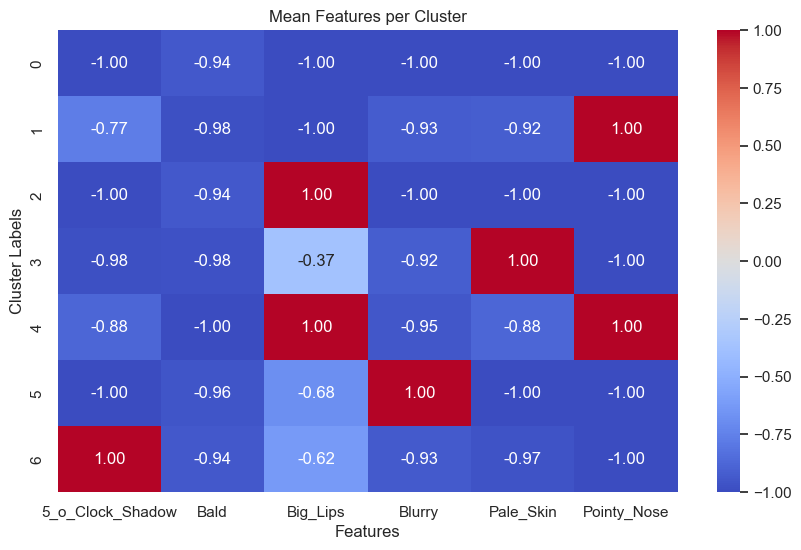

In [335]:
mean_features = clustered.groupby('kmeans').mean()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mean_features, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mean Features per Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster Labels')
plt.show()


In [162]:
clustered.to_csv("clustered.csv",index=False)


foldering

In [170]:
clustered_with_id=clustered.copy()
clustered_with_id['id']=image_data["image_id"]
clustered_with_id
clustered_with_id[clustered_with_id["id"]=="008131.jpg"]

,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose,kmeans,dbScan,id
8130,-1,-1,1,-1,-1,1,4,3,008131.jpg


In [165]:
output_dir = 'clustered_images_phase3'
os.makedirs(output_dir, exist_ok=True)
image_dir ="dataset/"

for label, group in clustered_with_id.groupby('kmeans'): 
    selected_images = group.sample(n=min(10, len(group)), random_state=42)
    
    cluster_dir = os.path.join(output_dir, f'cluster_{label}')
    os.makedirs(cluster_dir, exist_ok=True)
    

    for _, row in selected_images.iterrows():
        image_name = row['id'] 
        image_path = os.path.join(image_dir, image_name)
        
        if os.path.exists(image_path):  
            shutil.copy(image_path, cluster_dir)
        else:
            print(f"Image {image_name} not found in {image_dir}")

# Kmeans Clustering with eye color and skin color

In [124]:
seleceted_features_df2=seleceted_features_df.copy()
seleceted_features_df2["mean_eye_color"]=df_combined["mean_eye_color"]
seleceted_features_df2["mean_skin_color"]=df_combined["mean_skin_color"]
seleceted_features_df2['mean_skin_color'] = seleceted_features_df2['mean_skin_color'].fillna(seleceted_features_df2['mean_skin_color'].mean())
seleceted_features_df2['mean_eye_color'] = seleceted_features_df2['mean_eye_color'].fillna(seleceted_features_df2['mean_skin_color'].mean())
seleceted_features_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   5_o_Clock_Shadow  50000 non-null  int64  
 1   Bald              50000 non-null  int64  
 2   Big_Lips          50000 non-null  int64  
 3   Blurry            50000 non-null  int64  
 4   Pale_Skin         50000 non-null  int64  
 5   Pointy_Nose       50000 non-null  int64  
 6   mean_eye_color    40317 non-null  float64
 7   mean_skin_color   47230 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 3.1 MB


In [125]:
seleceted_features_df2['mean_skin_color'] = seleceted_features_df2['mean_skin_color'].fillna(seleceted_features_df2['mean_skin_color'].mean())
seleceted_features_df2['mean_eye_color'] = seleceted_features_df2['mean_eye_color'].fillna(seleceted_features_df2['mean_skin_color'].mean())
seleceted_features_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   5_o_Clock_Shadow  50000 non-null  int64  
 1   Bald              50000 non-null  int64  
 2   Big_Lips          50000 non-null  int64  
 3   Blurry            50000 non-null  int64  
 4   Pale_Skin         50000 non-null  int64  
 5   Pointy_Nose       50000 non-null  int64  
 6   mean_eye_color    50000 non-null  float64
 7   mean_skin_color   50000 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 3.1 MB


In [81]:
Kmeans_Clustering_color= KMeans(9, init="k-means++",algorithm="lloyd" ,random_state=42)
Kmeans_Clustering_color.fit(seleceted_features_df2)
labels = Kmeans_Clustering_color.labels_
metrics=[]
metrics.append({
            'Silhouette Score': silhouette_score(seleceted_features_df2, labels),
            'Davies-Bouldin Index': davies_bouldin_score(seleceted_features_df2, labels),
            'Calinski-Harabasz Index': calinski_harabasz_score(seleceted_features_df2, labels),
            'Inertia': Kmeans_Clustering_color.inertia_,
        })
metrics_df=pd.DataFrame(metrics)
metrics_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Inertia
0,0.384228,0.8612,36539.826136,1.031264e+07


# DBSCAN 

In [12]:
scaler = StandardScaler()


In [ ]:

# Hyperparameter tuning manually
param_grid = {
    'eps': np.arange(.5, 1,.1),
    'min_samples': [5,12,18]
}

best_score = -1
best_params = {}
resultDBScan = {

    'eps': [],
    'min_samples': [],
    'silhouette_score': [],
    'davies_bouldin_score': [],
    'calinski_harabasz_score':[],
    'clusters':[]

}
# Loop over all combinations of parameters
X_train = seleceted_features_df
X_train_cleaned = X_train.fillna(X_train.mean())
scaler = StandardScaler()

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:

        X_scaled_dbscan = scaler.fit_transform(X_train_cleaned)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscanPredict =dbscan.fit_predict(X_scaled_dbscan)
        labels =dbscan.labels_
        n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        
        score = silhouette_score(X_scaled_dbscan, labels)
        score1 = davies_bouldin_score(X_scaled_dbscan, labels)
        score2 = calinski_harabasz_score(X_scaled_dbscan, labels)
        n_clusters=len(set(dbscan.labels_))
        
        resultDBScan['eps'].append(eps)
        resultDBScan['min_samples'].append(min_samples)
        resultDBScan['silhouette_score'].append(score)
        resultDBScan['davies_bouldin_score'].append(score1)
        resultDBScan['calinski_harabasz_score'].append(score2)
        resultDBScan['clusters'].append(n_clusters)


In [ ]:
df_resultDBScan = pd.DataFrame(resultDBScan)

In [ ]:
df_resultDBScan

In [43]:
dbmetrics=[]
X_scaled = scaler.fit_transform(X_train_cleaned)

dbscan = DBSCAN(eps=.5, min_samples=12)
dbscanPredict =dbscan.fit_predict(seleceted_features_df)
clustered["dbScan"]=dbscan.labels_
clustered["dbScan"].value_counts()
len(clustered["dbScan"].value_counts())
dbmetrics.append({
            'Silhouette Score': silhouette_score(X_scaled, dbscan.labels_),
            'Davies-Bouldin Index': davies_bouldin_score(X_scaled, dbscan.labels_),
            'Calinski-Harabasz Index':calinski_harabasz_score(X_scaled, dbscan.labels_),
            'clusters': len(set(dbscan.labels_))
        })
dbmetrics_df=pd.DataFrame(dbmetrics)
dbmetrics_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,clusters
0,0.998333,0.95759,345011.393885,33


# MeanShift

In [145]:
bandwidth = estimate_bandwidth(seleceted_features_df, n_samples=5000)

print("Estimated Bandwidth:", bandwidth)

Estimated Bandwidth: 1.2433521059879113


select best parameter and score

In [182]:
X_train = seleceted_features_df
X_train_cleaned = X_train.fillna(X_train.mean())
scaler = StandardScaler()
X_scaled_meanShift = scaler.fit_transform(X_train_cleaned)

bandwidths = np.linspace(2, 2.5, 5)
silhouette_scores = []
resultMeanShift = {

    'bw': [],
    'silhouette_score': [],
    'davies_bouldin_score': [],
    'calinski_harabasz_score':[],
    'clusters':[]
    

}
for bw in bandwidths:
    ms = MeanShift(bandwidth=bw)
    labels = ms.fit_predict(X_scaled_meanShift)
    if len(set(labels)) > 1:
        score = silhouette_score(X_scaled_meanShift, labels)
        score1 = davies_bouldin_score(X_scaled_meanShift, labels)
        score2 = calinski_harabasz_score(X_scaled_meanShift, labels)
        silhouette_scores.append((bw, score))

        resultMeanShift['bw'].append(bw)
        resultMeanShift['clusters'].append(len(set(labels)))
        resultMeanShift['silhouette_score'].append(score)
        resultMeanShift['davies_bouldin_score'].append(score1)
        resultMeanShift['calinski_harabasz_score'].append(score2)
    else:
        silhouette_scores.append((bw, -1))

best_bw, best_score = max(silhouette_scores, key=lambda x: x[1])
print(f"Best bandwidth: {best_bw}, with silhouette score: {best_score}")


Best bandwidth: 2.0, with silhouette score: 0.9998599965723791


In [183]:
df_resultMeanShift = pd.DataFrame(resultMeanShift)
df_resultMeanShift

,bw,silhouette_score,davies_bouldin_score,calinski_harabasz_score,clusters
0,2.000,0.999860,4.689630e-08,3.322264e+29,47
1,2.125,0.999860,4.689630e-08,3.322264e+29,47
2,2.250,0.681856,5.471417e-01,1.054172e+04,25
3,2.375,0.592920,6.503576e-01,7.766572e+03,14
4,2.500,0.592920,6.503576e-01,7.766572e+03,14


In [14]:
msmetrics=[]

X_train = seleceted_features_df
X_train_cleaned = X_train.fillna(X_train.mean())
scaler = StandardScaler()
X_scaled_meanShift = scaler.fit_transform(X_train_cleaned)

final_ms = MeanShift(bandwidth=1.18)
final_labels = final_ms.fit_predict(X_scaled_meanShift)
len(set(labels))

clustered['MeanShift'] = final_labels
clustered['MeanShift']

msmetrics.append({
            'Silhouette Score': silhouette_score(X_scaled_meanShift, final_labels),
            'Davies-Bouldin Index': davies_bouldin_score(X_scaled_meanShift, final_labels),
            'Calinski-Harabasz Index':calinski_harabasz_score(X_scaled_meanShift, final_labels),
            'clusters': len(set(final_labels))
        })
msmetrics_df=pd.DataFrame(msmetrics)
msmetrics_df


,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,clusters
0,0.99986,4.689630e-08,3.322264e+29,47


# Phase 4


PCA 2D

In [27]:
clustered["image_id"]=image_data["image_id"]
clustered.to_csv("clustered_train_data.csv")

In [30]:
clustered.drop(columns=["kmeans","dbScan","MeanShift","image_id"])

,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose
0,-1,-1,-1,-1,-1,1
1,-1,-1,-1,-1,-1,-1
2,-1,-1,1,1,-1,1
3,-1,-1,-1,-1,-1,1
4,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...
49995,-1,-1,-1,-1,-1,1
49996,-1,-1,-1,-1,-1,1
49997,-1,-1,-1,-1,-1,-1
49998,-1,-1,1,-1,-1,-1


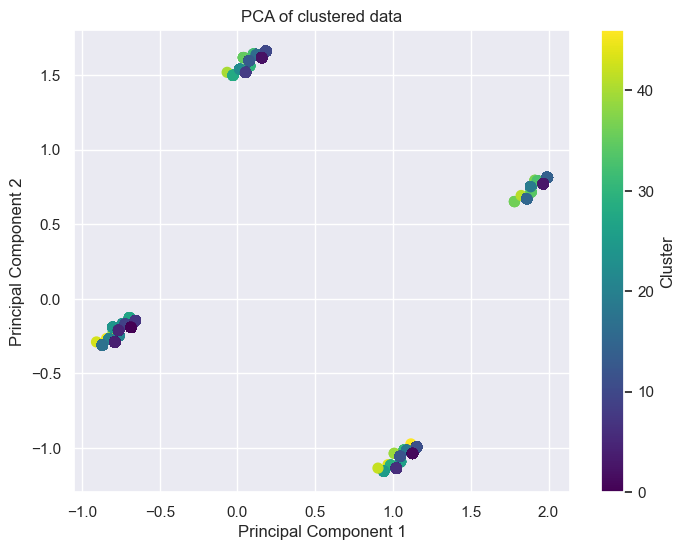

In [41]:
pca = PCA(n_components=2)  
data_pca = pca.fit_transform(clustered.drop(columns=["kmeans","dbScan","MeanShift","image_id"]))
sns.set(font_scale=1)

plt.figure(figsize=(8,6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clustered["MeanShift"], cmap='viridis', s=50) 
plt.title('PCA of clustered data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


PCA 3D

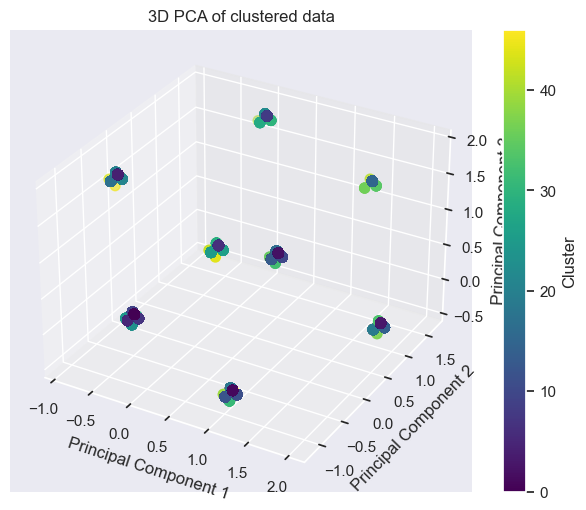

In [32]:
pca = PCA(n_components=3) 
data_pca = pca.fit_transform(clustered.drop(columns=["kmeans","dbScan","MeanShift","image_id"]))

# Create a 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], 
                     c=clustered["MeanShift"], cmap='viridis', s=50)

# Set labels and title
ax.set_title('3D PCA of clustered data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add color bar
cbar = plt.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

t-SNE 2D

In [35]:
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(clustered.drop(columns=["kmeans","dbScan","MeanShift","image_id"]))

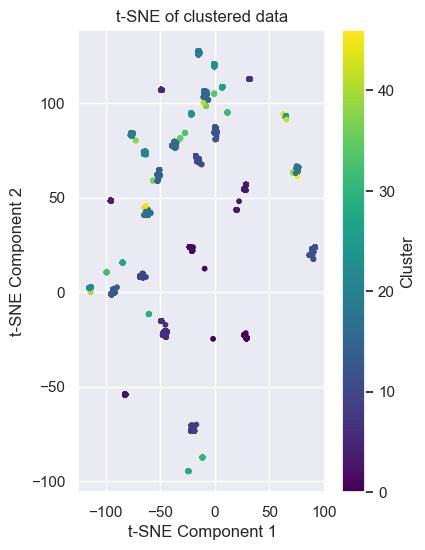

In [36]:
plt.figure(figsize=(4,6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clustered["MeanShift"], cmap='viridis', s=10)
plt.title('t-SNE of clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Phase 5


In [321]:
centroids =Kmeans_Clustering.cluster_centers_
pd.DataFrame( centroids
         )
clustered["kmeans"].unique()

array([1, 2, 0, 3, 4, 5, 6])

In [333]:
centroids =Kmeans_Clustering.cluster_centers_    
centroids_df = pd.DataFrame(centroids, columns=seleceted_features_df.columns)

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(clustered.drop(columns=["kmeans"]),clustered["kmeans"] )

neighbors_indices = neigh.kneighbors(centroids, n_neighbors=50, return_distance=False)


neighbors_labels = []

for i, indices in enumerate(neighbors_indices):
    labels = clustered.iloc[indices]["kmeans"].values
    neighbors_labels.append(labels)


neighbors_labels_df = pd.DataFrame(neighbors_labels, index=[f"Centroid_{i}" for i in range(len(centroids))])


C:\Users\Kia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [334]:
centroid_labels_counts = []

for labels in neighbors_labels:
    count = Counter(labels)
    centroid_labels_counts.append(count)

centroid_labels_counts_df = pd.DataFrame(centroid_labels_counts, index=[f"Centroid_{i}" for i in range(len(centroids))]).fillna(0)
centroid_labels_counts_df = centroid_labels_counts_df.astype(int)
centroid_labels_counts_df

,0,1,2,3,4,5,6
Centroid_0,50,0,0,0,0,0,0
Centroid_1,0,50,0,0,0,0,0
Centroid_2,0,0,50,0,0,0,0
Centroid_3,0,0,0,50,0,0,0
Centroid_4,0,0,0,0,50,0,0
Centroid_5,0,0,0,0,0,50,0
Centroid_6,0,0,0,0,0,0,50


# Phase 6

In [44]:
image_data_test = pd.read_csv(test_features)
image_data_test

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,050001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,-1,-1,1,-1,-1,1
1,050002.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,050003.jpg,-1,1,-1,1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,1,1,-1,-1
3,050004.jpg,1,-1,-1,-1,-1,-1,1,1,-1,...,-1,1,-1,-1,-1,1,-1,-1,-1,1
4,050005.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,050096.jpg,-1,-1,-1,1,-1,-1,-1,-1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
96,050097.jpg,-1,-1,1,-1,-1,-1,1,-1,1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1
97,050098.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,-1
98,050099.jpg,-1,-1,1,-1,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [49]:
image_files_test = [f for f in os.listdir(testImages) if f.lower().endswith(('.jpg'))]


In [51]:
test_data = pd.read_csv(test_features)
test_data.drop(columns=['image_id'],inplace=True)

X_test = test_data[selected_features]

X_test

,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose
0,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1
2,-1,-1,1,-1,-1,1
3,1,-1,1,-1,-1,1
4,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...
95,-1,-1,-1,-1,-1,-1
96,-1,-1,1,-1,-1,-1
97,-1,-1,-1,-1,-1,1
98,-1,-1,1,-1,-1,1


In [53]:
Kmeans_Clustering_test_predict = Kmeans_Clustering.predict(X_test)

X_test["kmean"] = Kmeans_Clustering_test_predict
X_test

C:\Users\Kia\AppData\Local\Temp\ipykernel_22596\259376872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["kmean"] = Kmeans_Clustering_test_predict


,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose,kmean
0,-1,-1,-1,-1,-1,-1,0
1,-1,-1,-1,-1,-1,-1,0
2,-1,-1,1,-1,-1,1,4
3,1,-1,1,-1,-1,1,4
4,-1,-1,1,-1,-1,1,4
...,...,...,...,...,...,...,...
95,-1,-1,-1,-1,-1,-1,0
96,-1,-1,1,-1,-1,-1,2
97,-1,-1,-1,-1,-1,1,1
98,-1,-1,1,-1,-1,1,4


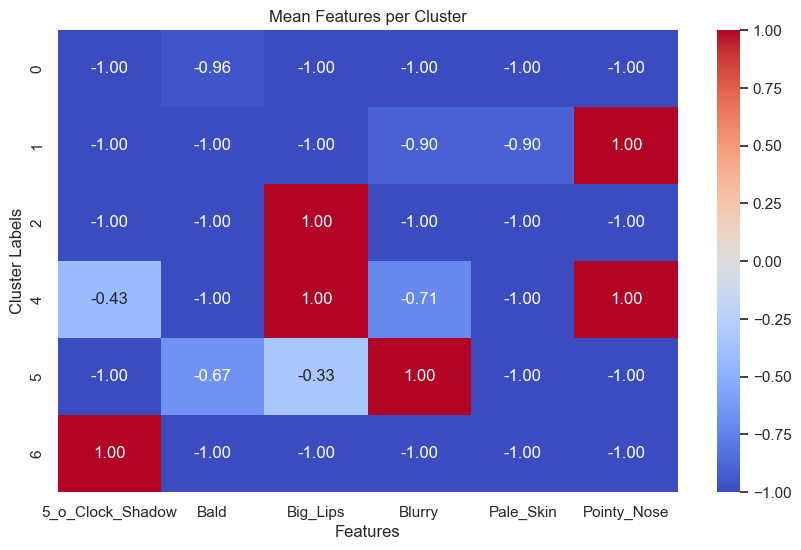

In [54]:
# Convert to DataFrame for easier manipulation
clustered_test = X_test.copy()
mean_features_test = clustered_test.groupby('kmean').mean()

# # Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mean_features_test, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mean Features per Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster Labels')
plt.show()





In [60]:
X_test["id"]=image_data_test["image_id"]
sampled_data = X_test.groupby(X_test["kmean"], as_index=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


C:\Users\Kia\AppData\Local\Temp\ipykernel_22596\1697943454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["id"]=image_data_test["image_id"]
C:\Users\Kia\AppData\Local\Temp\ipykernel_22596\1697943454.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = X_test.groupby(X_test["kmean"], as_index=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


In [61]:
if len(sampled_data) < 10:
    additional_samples = X_test.drop(sampled_data.index).sample(10 - len(sampled_data), random_state=1)
    sampled_data = pd.concat([sampled_data, additional_samples]).reset_index(drop=True)
sampled_data    

,5_o_Clock_Shadow,Bald,Big_Lips,Blurry,Pale_Skin,Pointy_Nose,kmean,id
0,-1,-1,-1,-1,-1,-1,0,050078.jpg
1,-1,-1,-1,-1,-1,1,1,050080.jpg
2,-1,-1,1,-1,-1,-1,2,050012.jpg
3,-1,-1,1,-1,-1,1,4,050008.jpg
4,-1,-1,1,1,-1,-1,5,050054.jpg
5,1,-1,-1,-1,-1,-1,6,050048.jpg
6,-1,-1,-1,-1,-1,-1,0,050047.jpg
7,1,-1,-1,-1,-1,-1,6,050038.jpg
8,-1,-1,1,-1,-1,-1,2,050052.jpg
9,-1,-1,-1,-1,-1,-1,0,050093.jpg


In [ ]:
base_folder = 'cluster_images_test'

os.makedirs(base_folder, exist_ok=True)
main_image_directory = "test/"


def find_and_copy_image(filename, cluster_folder):
    # Walk through all subdirectories in main_image_directory
    for root, _, files in os.walk(main_image_directory):
        if filename in files:
            source_path = os.path.join(root, filename)
            shutil.copy(source_path, cluster_folder)
            return True
    print(f"Image {filename} not found.")
    return False

for _, row in sampled_data.iterrows():
    cluster_label = row['kmean']
    filename = row['id']
    
    # Create the cluster-specific folder if it doesn't exist
    cluster_folder = os.path.join(base_folder, f'cluster_{cluster_label}')
    os.makedirs(cluster_folder, exist_ok=True)
    
    # Find and copy the image
    find_and_copy_image(filename, cluster_folder)



In [66]:
X_test.to_csv("X_test_with_labels.csv",index=False)